In [32]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import json
from nltk import pos_tag
from nltk.corpus import wordnet as wn

class TextPreprocessor:
    def __init__(self, contractions_path=None, custom_stopwords_list=None, words_to_keep=None):
        if words_to_keep is None:
            words_to_keep = ['not']
        self.words_to_keep = set(words_to_keep)
        self.stop_words = set(stopwords.words('english')).difference(self.words_to_keep)
        if custom_stopwords_list is not None:
            self.stop_words.update([word for word in custom_stopwords_list if word not in self.words_to_keep])
        self.lemmatizer = WordNetLemmatizer()
        if contractions_path is not None:
            with open(contractions_path, 'r') as file:
                self.contractions = json.load(file)
                self.contractions = {k.lower(): v.lower() for k, v in self.contractions.items()}
        else:
            self.contractions = {}

    def replace_contractions(self, text):
        return ' '.join([self.contractions[word] if word in self.contractions else word for word in text.split()])
    

    def preprocess_text(self, text, word_freq=None):
        text = text.lower()
        text = self.replace_contractions(text)
        # text = re.sub(r'[^a-z0-9\s\?!\'"]', ' ', text) 
        text = re.sub(r'[^a-z0-9\s\?!]', ' ', text)  

        text = re.sub(r'\s+', ' ', text).strip()

        tokens = word_tokenize(text) 

        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        filtered_tokens = [word for word in lemmatized_tokens if word not in self.stop_words and (word_freq is None or word_freq.get(word, 0) >= 3)]

        lemmatized_text = ' '.join(filtered_tokens)
        return lemmatized_text

    def preprocess_csv(self, input_file_path, output_file_path):
        df = pd.read_csv(input_file_path)
        

        word_freq = Counter()
        for text in df['Review'].astype(str):
            tokens = word_tokenize(text.lower())
            word_freq.update(tokens)
        
        df['Review'] = df['Review'].apply(lambda x: self.preprocess_text(str(x), word_freq=word_freq))
        shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        shuffled_df.to_csv(output_file_path, index=False)
        print(f"Processed and shuffled dataset has been saved to: {output_file_path}")

custom_stopwords_list = [
    'be', 'am', 'are', 'is', 'and', 'who', 'in', 'at', 'alexand', 'how', 'to', 'as', 'a', 'an', 'the', 'of', 'for', 'it', 'my', 'do', 'did', 'then', 'that', 'this', 'those', 'html', 'will', 'would', 'bayesian', 'andrew', 'android', 'we', 'greek', 'js', 'astrobiolog', 'astronomi', 'ableton', 'api', 'benchmark', 'angular', 'ancient', 'arduino', 'about', 'algo', 'bootstrap', 'buddhism', 'adam', 'ajax', 'algebra', 'anyon', 'algorithm', 'if', 'i', 'you', 'capston', 'camp', 'caption', 'car', 'card', 'care', 'camera', 'campaign', 'captur', 'america', 'american', 'web', 'all'
]

words_to_keep = [
    'not', 'no', 'very', 'really', 'quite', 'extremely', 'totally', 'absolutely', 'completely', 'utterly',
    'but', 'however', 'although', 'though', 'never', 'none', 'nothing', 'nobody', 'nowhere', 'more', 'less',
    'better', 'worse', 'easier', 'harder', 'if', 'unless', 'only', 'except'
]

preprocessor = TextPreprocessor(contractions_path='../input/contraction/contractions.json', custom_stopwords_list=custom_stopwords_list, words_to_keep=words_to_keep)

input_file_path = '../data/raw/reviews.csv'
output_file_path = '../data/processed/reviews_processed.csv'
preprocessor.preprocess_csv(input_file_path, output_file_path)


Processed and shuffled dataset has been saved to: ../data/processed/reviews_processed.csv


In [33]:
import pandas as pd

df = pd.read_csv('../data/processed/reviews_processed.csv') 

filtered_df = df[(df['Label'] >= 1) & (df['Label'] <= 2) & (df['Review'].str.split().str.len() < 3)]

print(filtered_df)


           Id          Review  Label
72      14055         basic !      2
285     35717          simple      2
2271    17836          boring      1
2476    36567    introduction      2
2718    74190  very essential      2
...       ...             ...    ...
105300  32733  broad overview      2
105721  65310     good course      2
106054  71774    basic simple      1
106163  18017      video long      1
106912  40774     mind boring      1

[203 rows x 3 columns]


In [34]:
import pandas as pd
from nltk.tokenize import word_tokenize

df = pd.read_csv('../data/processed/reviews_processed.csv')
df = df.dropna(subset=['Review'])

def word_count(text):
    return len(word_tokenize(text))

df = df[df['Review'].apply(word_count) >= 3]

df.to_csv('../data/processed/reviews_processed.csv', index=False)


In [2]:
import pandas as pd
output_file_path = '..//data//processed//reviews_processed.csv'

processed_df = pd.read_csv(output_file_path)

label_counts = processed_df['Label'].value_counts()

print(label_counts)

5    73686
4    17127
3     4902
1     2355
2     2161
Name: Label, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

output_file_path = '..//data//raw//reviews.csv'

processed_df = pd.read_csv(output_file_path)

def map_labels(label):
    if label in [0, 1]:
        return 'Negative'
    elif label == 2:
        return 'Neutral'
    elif label in [3, 4]:
        return 'Positive'

processed_df['Category'] = processed_df['Label'].apply(map_labels)

category_counts = processed_df['Category'].value_counts()

plt.figure(figsize=(5, 4))  
category_counts.plot(kind='bar')  
plt.title('Count of Each Category')  
plt.xlabel('Category')  
plt.ylabel('Count')  
plt.xticks(rotation=0) 
plt.show() 

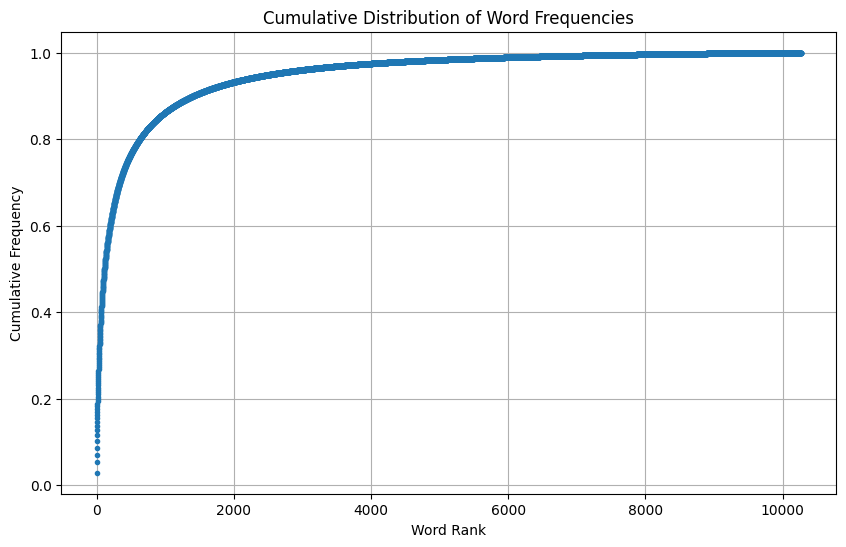

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np

df = pd.read_csv('../data/processed/reviews_processed.csv')
word_counts = Counter()

df['Review'].str.split().apply(word_counts.update)

frequencies = sorted(word_counts.values(), reverse=True)

cumulative_frequencies = np.cumsum(frequencies) / sum(frequencies)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_frequencies, marker='.', linestyle='none')
plt.xlabel('Word Rank')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Distribution of Word Frequencies')
plt.grid(True)
plt.show()


In [38]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

df = pd.read_csv('../data/processed/reviews_processed.csv')

all_text = ' '.join(df['Review'].tolist())

words = word_tokenize(all_text)

vocabulary = set(words)

vocab_size = len(vocabulary)

print(f'Vocabulary size: {vocab_size}')


Vocabulary size: 10748


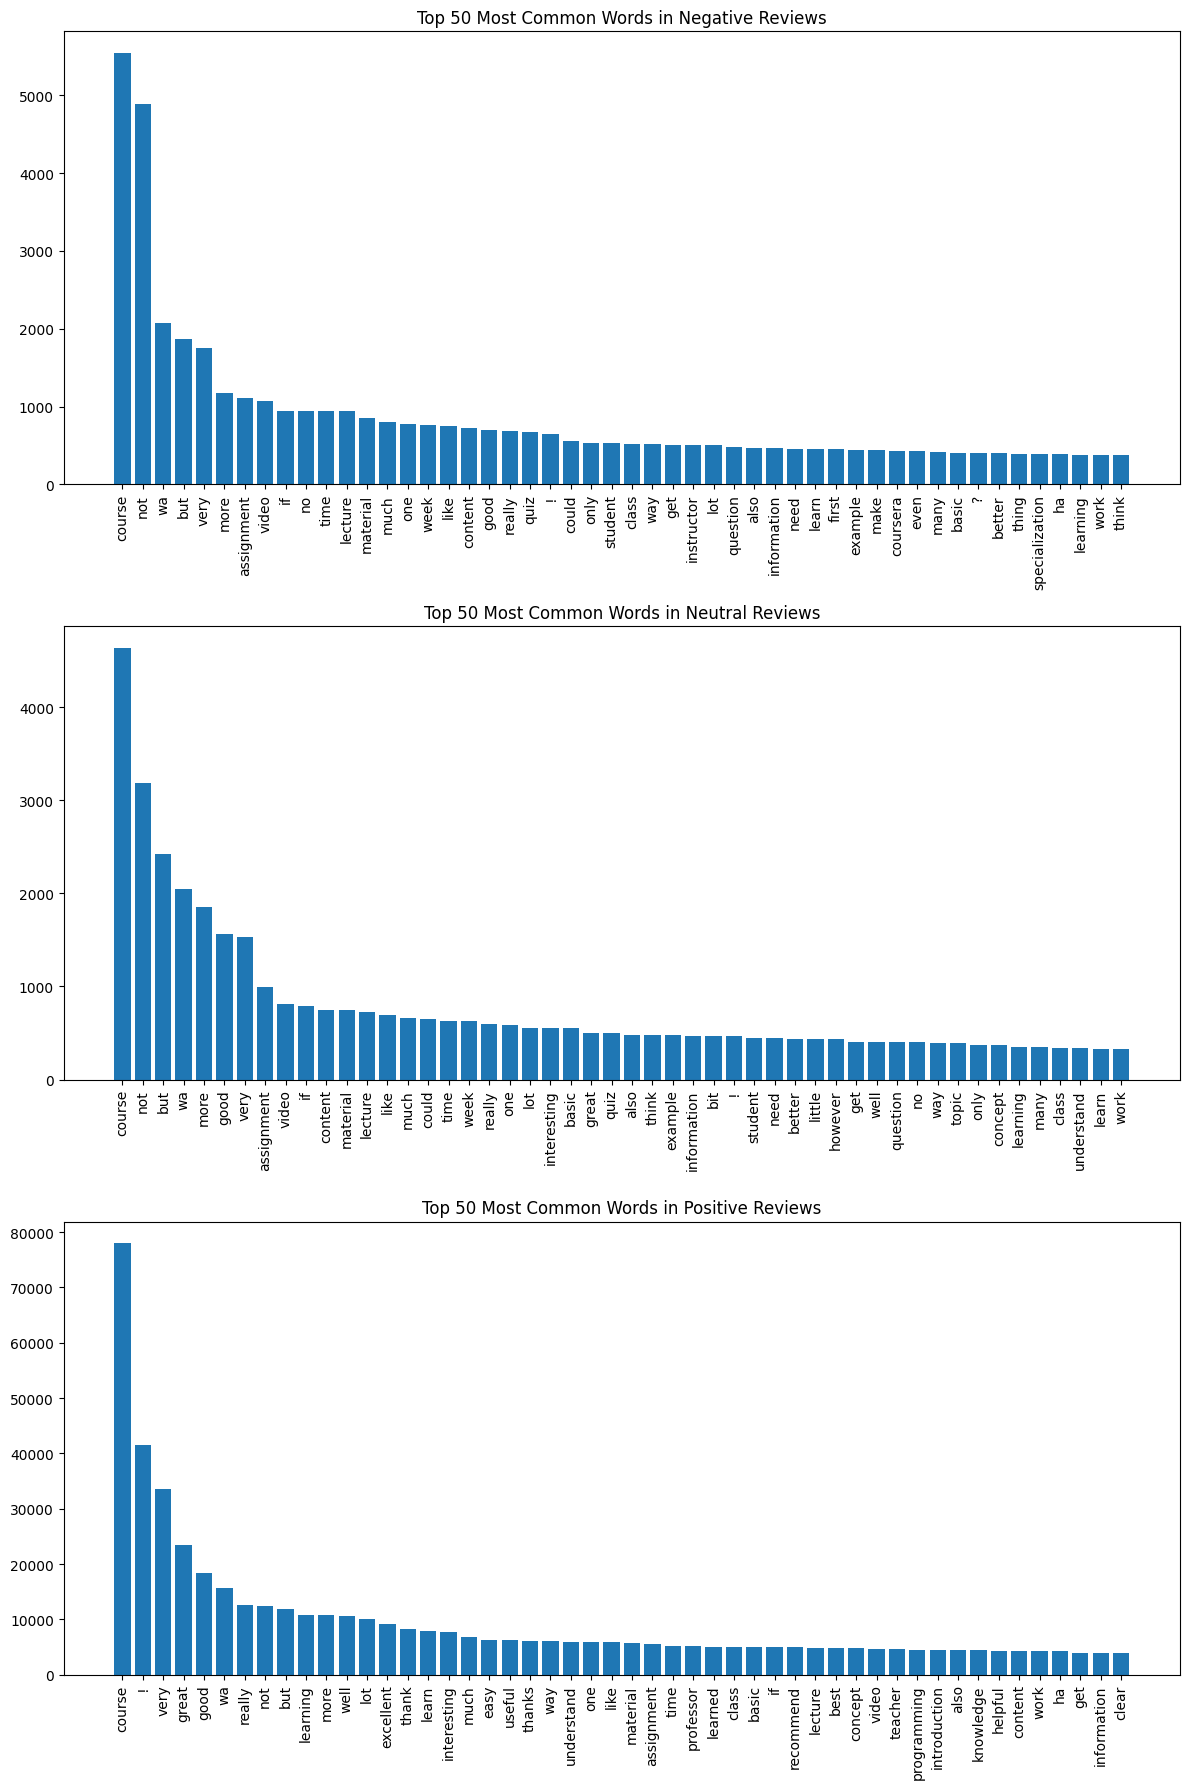

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

df = pd.read_csv('../data/processed/reviews_processed.csv')

df['Sentiment'] = df['Label'].apply(lambda x: 'Positive' if x in [4, 5] else ('Neutral' if x == 3 else 'Negative'))

negative_reviews = df[df['Sentiment'] == 'Negative']['Review']
neutral_reviews = df[df['Sentiment'] == 'Neutral']['Review']
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']

def get_word_frequencies(reviews):
    frequencies = Counter()
    for review in reviews:
        for word in word_tokenize(review):
            frequencies[word] += 1
    return frequencies

negative_freq = get_word_frequencies(negative_reviews)
neutral_freq = get_word_frequencies(neutral_reviews)
positive_freq = get_word_frequencies(positive_reviews)

most_common_negative = negative_freq.most_common(50)
most_common_neutral = neutral_freq.most_common(50)
most_common_positive = positive_freq.most_common(50)

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

neg_words, neg_counts = zip(*most_common_negative)
ax[0].bar(neg_words, neg_counts)
ax[0].set_title('Top 50 Most Common Words in Negative Reviews')
ax[0].tick_params(axis='x', rotation=90)

neu_words, neu_counts = zip(*most_common_neutral)
ax[1].bar(neu_words, neu_counts)
ax[1].set_title('Top 50 Most Common Words in Neutral Reviews')
ax[1].tick_params(axis='x', rotation=90)

pos_words, pos_counts = zip(*most_common_positive)
ax[2].bar(pos_words, pos_counts)
ax[2].set_title('Top 50 Most Common Words in Positive Reviews')
ax[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


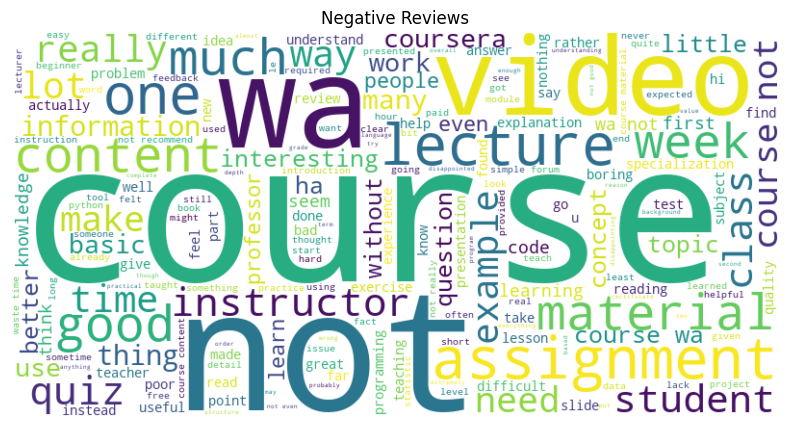

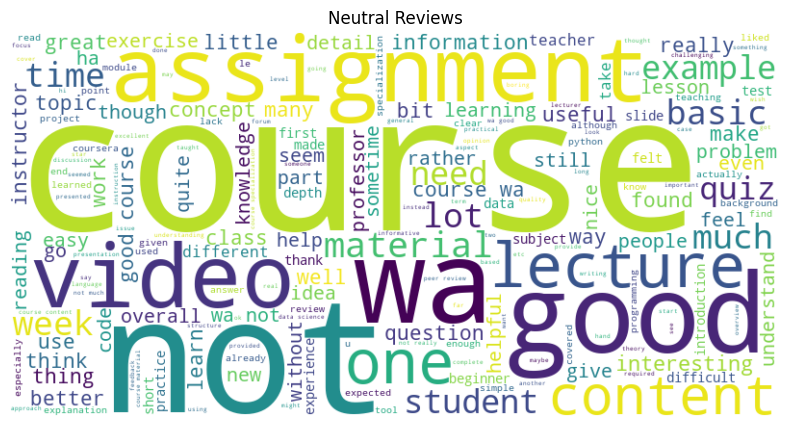

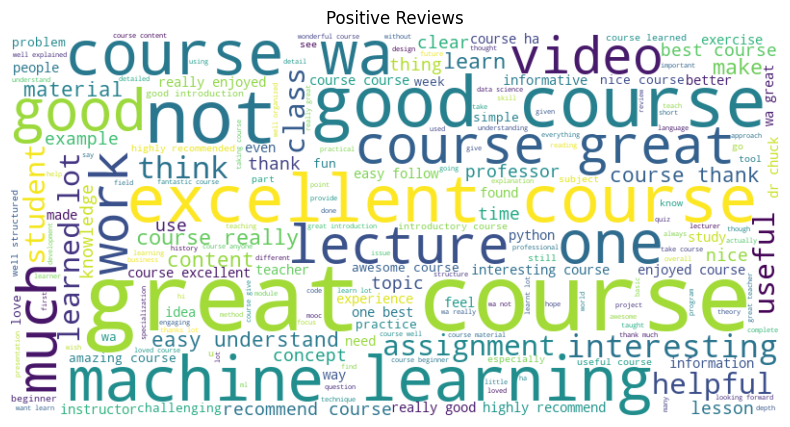

In [39]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter

df = pd.read_csv('../data/processed/reviews_processed.csv')

df['Sentiment'] = df['Label'].apply(lambda x: 'Positive' if x in [4, 5] else ('Neutral' if x == 3 else 'Negative'))

stopwords = set(STOPWORDS)

stopwords.remove('not')  


negative_reviews = ' '.join(df[df['Sentiment'] == 'Negative']['Review'])
neutral_reviews = ' '.join(df[df['Sentiment'] == 'Neutral']['Review'])
positive_reviews = ' '.join(df[df['Sentiment'] == 'Positive']['Review'])

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_wordcloud(negative_reviews, 'Negative Reviews')
generate_wordcloud(neutral_reviews, 'Neutral Reviews')
generate_wordcloud(positive_reviews, 'Positive Reviews')


In [17]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter

df = pd.read_csv('../data/processed/reviews_processed.csv')

word_frequencies = Counter()

for review in df['Review']:
    tokens = word_tokenize(review)
    word_frequencies.update(tokens)

low_freq_words = {word: freq for word, freq in word_frequencies.items() if freq == 2}

print("Words with frequency less than 3:")
for word, freq in low_freq_words.items():
    print(f"{word}: {freq}")


Words with frequency less than 3:
striving: 2
viewed: 2
exploring: 2
infos: 2
shifting: 2
listens: 2
breaks: 2
catching: 2
landing: 2
robots: 2
energized: 2
considers: 2
usefu: 2
networks: 2
broke: 2
interwoven: 2
explored: 2
edifying: 2
faced: 2
rethinking: 2
dreaded: 2
columns: 2
playfulness: 2
empowers: 2
initiatives: 2
fulfilled: 2
deepened: 2
purchasing: 2
subjected: 2
visualized: 2
flipped: 2
pouring: 2
responds: 2
lifechanging: 2
discovered: 2
responsibilities: 2
illustrating: 2
discouraged: 2
comprises: 2
translated: 2
bordering: 2
founded: 2
downloading: 2
retailing: 2
undertaking: 2
derivatives: 2
gaining: 2
wondering: 2
las: 2
elucidates: 2
sirs: 2
transforms: 2
visionary: 2
routing: 2
scanning: 2
differs: 2
menus: 2
customized: 2
wounder: 2
solves: 2
fought: 2
rocking: 2
supported: 2
biginner: 2
wound: 2
streamlined: 2
watched: 2
elias: 2
crises: 2
narrated: 2
achieved: 2
links: 2
underlining: 2
checked: 2
moc: 2
scaling: 2
rendering: 2
extras: 2
treated: 2
teached: 2
empha

In [ ]:
import pandas as pd

file_path = '../data/processed/reviews_processed.csv'  
data = pd.read_csv(file_path)

filtered_data_high_labels = data[data['Label'].isin([4, 5])]

reduced_high_labels = filtered_data_high_labels.sample(frac=1/6, random_state=1)

filtered_data_other_labels = data[~data['Label'].isin([4, 5])]

balanced_data = pd.concat([reduced_high_labels, filtered_data_other_labels])

shuffled_data = balanced_data.sample(frac=1, random_state=1)

save_path = '../data/processed/reviews_processed.csv'
shuffled_data.to_csv(save_path, index=False)
